# SHAP分析

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'IPAexGothic'
import seaborn as sns
import re
import shap
from tqdm import tqdm
import japanize_matplotlib
import pickle
import warnings
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 2000

In [2]:
import seaborn as sns
sns.set()
sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='IPAexGothic')

In [3]:
# 末尾に"/"を付与すること
PATH_INPUT_RESULT = '../results/'
PATH_INPUT_MODEL = '../models/'

In [4]:
from scipy.optimize import bisect

# 正常再現率を90%とする閾値を決定
def calc_diff_90percent(df):
    def _curried(thres):
        df['pred_rekka'] = (df['rekka_score'] > thres).astype(int)
        seijo_recall = len(df[(df['rekka_flg'] == 0) & (df['pred_rekka'] == 0)]) / len(df[df['rekka_flg'] == 0])
        diff = seijo_recall - 0.9
        return diff
    return _curried

# 閾値計算
def calc_thres(df):
    return round(bisect(calc_diff_90percent(df), 0, 1), 6)

## 使用データ

### ベストモデル 結果

In [5]:
df_results = pd.read_csv(PATH_INPUT_RESULT+'results.csv', index_col=0)
df_results = df_results.query('fold_id == 3')
df_results.reset_index(drop=True, inplace=True)

In [6]:
auc = round(roc_auc_score(df_results['rekka_flg'], df_results['rekka_score']),10)
thres = calc_thres(df_results)
df_results['rekka_pred'] = df_results['rekka_score'] >= thres
cr = classification_report(df_results['rekka_flg'], df_results['rekka_pred'], digits=3)
display(df_results.head(1))
print('AUC: {0}'.format(auc))
print('閾値: {0}'.format(thres))
print(cr)

,GODCUSTCD,RECKSYM,recksym_kakuzuke_zenki,recksym_kakuzuke,recksym_henkobi,recksym_kakuzuke_zenki_kigo,recksym_kakuzuke_kigo,rekka_flg,fold_id,RECKTRANS,0_預金_入金_金額,1_預金_入金_金額,2_預金_入金_金額,3_預金_入金_金額,4_預金_入金_金額,5_預金_入金_金額,6_預金_入金_金額,7_預金_入金_金額,8_預金_入金_金額,9_預金_入金_金額,10_預金_入金_金額,11_預金_入金_金額,0_預金_入金_件数,1_預金_入金_件数,2_預金_入金_件数,3_預金_入金_件数,4_預金_入金_件数,5_預金_入金_件数,6_預金_入金_件数,7_預金_入金_件数,8_預金_入金_件数,9_預金_入金_件数,10_預金_入金_件数,11_預金_入金_件数,0_預金_出金_金額,1_預金_出金_金額,2_預金_出金_金額,3_預金_出金_金額,4_預金_出金_金額,5_預金_出金_金額,6_預金_出金_金額,7_預金_出金_金額,8_預金_出金_金額,9_預金_出金_金額,10_預金_出金_金額,11_預金_出金_金額,0_預金_出金_件数,1_預金_出金_件数,2_預金_出金_件数,3_預金_出金_件数,4_預金_出金_件数,5_預金_出金_件数,6_預金_出金_件数,7_預金_出金_件数,8_預金_出金_件数,9_預金_出金_件数,10_預金_出金_件数,11_預金_出金_件数,0_月末残高_普通,1_月末残高_普通,2_月末残高_普通,3_月末残高_普通,4_月末残高_普通,5_月末残高_普通,6_月末残高_普通,7_月末残高_普通,8_月末残高_普通,9_月末残高_普通,10_月末残高_普通,11_月末残高_普通,rekka_score,pred_rekka,rekka_pred
0,6316050371,201605,14,14,20161202,A4,A4,False,3,201602,0.309379,0.402722,0.413674,0.237665,0.415987,0.188809,1.0,0.501447,0.052528,0.228235,0.114766,0.233668,0.930233,1.0,0.755814,0.651163,0.604651,0.802326,0.697674,0.732558,0.732558,0.72093,0.593023,0.627907,0.293356,0.450809,0.401411,0.309526,0.395084,0.259709,1.0,0.250077,0.185786,0.256498,0.144042,0.241772,0.942857,0.957143,1.0,0.928571,0.957143,0.942857,0.957143,0.885714,0.857143,0.928571,0.885714,0.914286,0.001008,0.001008,0.001008,0.001008,0.001008,0.001008,0.001008,0.999947,0.999947,0.999947,0.999947,1.0,0.001339,0,False


AUC: 0.6245764029
閾値: 0.035403
             precision    recall  f1-score   support

      False      0.966     0.901     0.932       919
       True      0.062     0.171     0.091        35

avg / total      0.933     0.874     0.902       954



In [7]:
X_test = df_results.iloc[:,10:-3]
X_test.head()

,0_預金_入金_金額,1_預金_入金_金額,2_預金_入金_金額,3_預金_入金_金額,4_預金_入金_金額,5_預金_入金_金額,6_預金_入金_金額,7_預金_入金_金額,8_預金_入金_金額,9_預金_入金_金額,10_預金_入金_金額,11_預金_入金_金額,0_預金_入金_件数,1_預金_入金_件数,2_預金_入金_件数,3_預金_入金_件数,4_預金_入金_件数,5_預金_入金_件数,6_預金_入金_件数,7_預金_入金_件数,8_預金_入金_件数,9_預金_入金_件数,10_預金_入金_件数,11_預金_入金_件数,0_預金_出金_金額,1_預金_出金_金額,2_預金_出金_金額,3_預金_出金_金額,4_預金_出金_金額,5_預金_出金_金額,6_預金_出金_金額,7_預金_出金_金額,8_預金_出金_金額,9_預金_出金_金額,10_預金_出金_金額,11_預金_出金_金額,0_預金_出金_件数,1_預金_出金_件数,2_預金_出金_件数,3_預金_出金_件数,4_預金_出金_件数,5_預金_出金_件数,6_預金_出金_件数,7_預金_出金_件数,8_預金_出金_件数,9_預金_出金_件数,10_預金_出金_件数,11_預金_出金_件数,0_月末残高_普通,1_月末残高_普通,2_月末残高_普通,3_月末残高_普通,4_月末残高_普通,5_月末残高_普通,6_月末残高_普通,7_月末残高_普通,8_月末残高_普通,9_月末残高_普通,10_月末残高_普通,11_月末残高_普通
0,0.309379,0.402722,0.413674,0.237665,0.415987,0.188809,1.000000,0.501447,0.052528,0.228235,0.114766,0.233668,0.930233,1.000000,0.755814,0.651163,0.604651,0.802326,0.697674,0.732558,0.732558,0.720930,0.593023,0.627907,0.293356,0.450809,0.401411,0.309526,0.395084,0.259709,1.000000,0.250077,0.185786,0.256498,0.144042,0.241772,0.942857,0.957143,1.000000,0.928571,0.957143,0.942857,0.957143,0.885714,0.857143,0.928571,0.885714,0.914286,0.001008,0.001008,0.001008,0.001008,0.001008,0.001008,0.001008,0.999947,0.999947,0.999947,0.999947,1.000000
1,1.000000,0.903294,0.964535,0.389743,0.611038,0.090167,0.161110,0.276521,0.387339,0.157787,0.526023,0.264512,0.786517,1.000000,0.617978,0.550562,0.505618,0.629213,0.629213,0.550562,0.674157,0.505618,0.662921,0.606742,0.766804,1.000000,0.496115,0.853482,0.362827,0.493238,0.404793,0.241279,0.159293,0.379775,0.449613,0.219638,0.925373,0.925373,1.000000,0.985075,0.925373,0.985075,0.925373,0.910448,0.791045,0.880597,0.835821,0.835821,1.000000,1.000000,1.000000,0.001084,0.001084,0.001094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.553654,0.356657,0.403896,0.652494,0.520228,0.183140,1.000000,0.147444,0.215441,0.217957,0.274237,0.229957,0.771429,1.000000,0.685714,0.571429,0.700000,0.857143,0.914286,0.700000,0.814286,0.785714,0.928571,0.714286,0.745448,0.644158,0.679285,0.851732,0.642907,0.580256,0.784878,1.000000,0.248427,0.313720,0.440284,0.365769,0.880597,0.910448,1.000000,0.970149,0.895522,0.940299,0.850746,0.940299,0.910448,0.895522,0.940299,0.880597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.647910,1.000000,0.366253,0.357559,0.760441,0.498097,0.573377,0.382870,0.475667,0.523557,0.600425,0.253839,0.706667,0.840000,0.853333,0.813333,0.733333,0.853333,0.853333,0.826667,0.826667,0.586667,1.000000,0.800000,0.476503,1.000000,0.400116,0.343557,0.736927,0.495561,0.508980,0.379030,0.387537,0.615696,0.588922,0.212709,0.810345,0.948276,0.844828,0.793103,0.775862,1.000000,0.844828,0.758621,0.793103,0.741379,0.827586,0.603448,0.127506,0.693794,0.564204,0.428313,0.756837,0.428812,0.311388,0.641909,0.530847,0.661410,1.000000,0.439224
4,0.341328,0.427410,0.559791,0.275985,0.461727,0.208327,0.236491,1.000000,0.761120,0.332709,0.462249,0.639205,0.852941,0.882353,1.000000,0.823529,0.970588,0.852941,0.735294,0.867647,0.897059,0.750000,0.661765,0.852941,0.394524,0.437878,0.497611,0.207538,0.305822,0.207334,0.287970,0.356993,1.000000,0.520794,0.421213,0.556813,0.803922,1.000000,0.901961,0.725490,1.000000,0.862745,0.666667,1.000000,0.882353,0.901961,0.803922,0.862745,0.342659,0.161558,0.128547,0.910732,1.000000,0.737946,0.643671,0.398333,0.267657,0.175903,0.158956,0.374822


In [8]:
df_results_rekka_rekka = df_results.query('rekka_flg==True & rekka_pred==True')
df_results_rekka_rekka = df_results_rekka_rekka.sort_values('rekka_score', ascending=False)
ind_rekka_rekka = df_results_rekka_rekka.head().index
print(ind_rekka_rekka)
display(df_results_rekka_rekka.head())

Int64Index([262, 706, 670, 874, 725], dtype='int64')


,GODCUSTCD,RECKSYM,recksym_kakuzuke_zenki,recksym_kakuzuke,recksym_henkobi,recksym_kakuzuke_zenki_kigo,recksym_kakuzuke_kigo,rekka_flg,fold_id,RECKTRANS,0_預金_入金_金額,1_預金_入金_金額,2_預金_入金_金額,3_預金_入金_金額,4_預金_入金_金額,5_預金_入金_金額,6_預金_入金_金額,7_預金_入金_金額,8_預金_入金_金額,9_預金_入金_金額,10_預金_入金_金額,11_預金_入金_金額,0_預金_入金_件数,1_預金_入金_件数,2_預金_入金_件数,3_預金_入金_件数,4_預金_入金_件数,5_預金_入金_件数,6_預金_入金_件数,7_預金_入金_件数,8_預金_入金_件数,9_預金_入金_件数,10_預金_入金_件数,11_預金_入金_件数,0_預金_出金_金額,1_預金_出金_金額,2_預金_出金_金額,3_預金_出金_金額,4_預金_出金_金額,5_預金_出金_金額,6_預金_出金_金額,7_預金_出金_金額,8_預金_出金_金額,9_預金_出金_金額,10_預金_出金_金額,11_預金_出金_金額,0_預金_出金_件数,1_預金_出金_件数,2_預金_出金_件数,3_預金_出金_件数,4_預金_出金_件数,5_預金_出金_件数,6_預金_出金_件数,7_預金_出金_件数,8_預金_出金_件数,9_預金_出金_件数,10_預金_出金_件数,11_預金_出金_件数,0_月末残高_普通,1_月末残高_普通,2_月末残高_普通,3_月末残高_普通,4_月末残高_普通,5_月末残高_普通,6_月末残高_普通,7_月末残高_普通,8_月末残高_普通,9_月末残高_普通,10_月末残高_普通,11_月末残高_普通,rekka_score,pred_rekka,rekka_pred
262,6436269960,201702,0,24,20170727,0,B4,True,3,201611,0.000000,0.595833,0.604171,0.625000,0.770833,1.000000,0.008333,0.604167,0.595833,0.625000,0.604167,0.604167,0.000000,0.500000,0.500000,0.750000,0.750000,1.000000,0.500000,0.250000,0.250000,0.500000,0.250000,0.250000,0.944937,0.949395,0.947258,0.949388,0.944983,0.943364,0.938192,0.941319,0.940159,0.937163,1.000000,0.931348,0.666667,1.000000,0.666667,1.000000,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,1.000000,0.666667,0.013830,0.000988,0.004449,0.040657,0.326792,1.000000,0.011252,0.021054,0.018083,0.067358,0.014440,0.034898,0.186535,1,True
706,8316196910,201705,16,23,20171102,A6,B3,True,3,201702,1.000000,0.052438,0.081267,0.007123,0.026303,0.034335,0.025644,0.032368,0.113612,0.033283,0.045976,0.004016,1.000000,0.333333,0.444444,0.222222,0.444444,0.555556,0.444444,0.555556,0.555556,0.333333,0.333333,0.222222,1.000000,0.003525,0.572336,0.121535,0.003525,0.081972,0.042755,0.047535,0.172929,0.003525,0.080948,0.042451,0.714286,0.285714,1.000000,0.857143,0.285714,0.857143,0.571429,0.714286,0.857143,0.285714,0.857143,0.571429,0.868563,1.000000,0.207497,0.012612,0.075453,0.021515,0.013685,0.015105,0.009399,0.090561,0.068975,0.004913,0.165676,1,True
670,8316174136,201608,16,21,20170131,A6,B1,True,3,201605,0.278064,0.351015,0.297522,1.000000,0.327990,0.318854,0.319776,0.309868,0.207227,0.319621,0.334136,0.303238,0.500000,0.875000,0.875000,0.875000,0.625000,0.375000,0.625000,0.625000,1.000000,0.375000,0.625000,0.500000,0.671343,0.939567,0.649227,1.000000,0.733641,0.801674,0.724546,0.789874,0.653540,0.676268,0.668832,0.701284,0.587500,0.650000,0.575000,0.587500,0.612500,0.900000,0.637500,0.975000,1.000000,0.812500,0.750000,0.600000,1.000000,0.238565,0.285183,0.410676,0.266394,0.393258,0.476511,0.109266,0.233438,0.353383,0.254350,0.382780,0.066903,1,True
874,8556079448,201602,16,24,20170313,A6,B4,True,3,201511,0.581918,0.406394,0.375350,1.000000,0.440791,0.283114,0.287523,0.528923,0.382455,0.341506,0.283875,0.376111,0.750000,0.750000,1.000000,1.000000,0.750000,0.500000,0.500000,0.750000,1.000000,0.750000,0.500000,0.750000,0.456318,0.343391,0.332632,1.000000,0.456034,0.101626,0.452145,0.402194,0.308557,0.307013,0.040300,0.468830,0.533333,0.466667,0.466667,1.000000,0.466667,0.133333,0.666667,0.400000,0.400000,0.400000,0.133333,0.666667,1.000000,0.983920,0.927865,0.475453,0.235444,0.590664,0.022195,0.120386,0.144151,0.081504,0.601719,0.184651,0.065081,1,True
725,8316203885,201711,16,31,20180411,A6,C,True,3,201708,1.000000,0.463892,0.575066,0.572830,0.609327,0.638223,0.903123,0.574661,0.823705,0.878960,0.421820,0.753425,0.888889,0.666667,0.888889,0.777778,0.777778,0.888889,1.000000,0.666667,0.888889,0.888889,0.666667,0.888889,0.493647,0.487585,0.507041,0.220386,0.935383,0.696008,0.501864,0.478550,1.000000,0.507263,0.601535,0.500894,0.750000,0.750000,0.750000,0.750000,1.000000,1.000000,0.750000,0.750000,1.000000,0.750000,0.875000,0.750000,0.724291,0.568384,0.541286,1.000000,0.292019,0.034550,0.494325,0.515246,0.009410,0.424762,0.013137,0.256428,0.044302,1,True


In [9]:
df_results_seijo_seijo = df_results.query('rekka_flg==False & rekka_pred==False')
df_results_seijo_seijo = df_results_seijo_seijo.sort_values('rekka_score', ascending=True)
ind_seijo_seijo = df_results_seijo_seijo.head(5).index
print(ind_seijo_seijo)
display(df_results_seijo_seijo.head())

Int64Index([437, 758, 768, 12, 326], dtype='int64')


,GODCUSTCD,RECKSYM,recksym_kakuzuke_zenki,recksym_kakuzuke,recksym_henkobi,recksym_kakuzuke_zenki_kigo,recksym_kakuzuke_kigo,rekka_flg,fold_id,RECKTRANS,0_預金_入金_金額,1_預金_入金_金額,2_預金_入金_金額,3_預金_入金_金額,4_預金_入金_金額,5_預金_入金_金額,6_預金_入金_金額,7_預金_入金_金額,8_預金_入金_金額,9_預金_入金_金額,10_預金_入金_金額,11_預金_入金_金額,0_預金_入金_件数,1_預金_入金_件数,2_預金_入金_件数,3_預金_入金_件数,4_預金_入金_件数,5_預金_入金_件数,6_預金_入金_件数,7_預金_入金_件数,8_預金_入金_件数,9_預金_入金_件数,10_預金_入金_件数,11_預金_入金_件数,0_預金_出金_金額,1_預金_出金_金額,2_預金_出金_金額,3_預金_出金_金額,4_預金_出金_金額,5_預金_出金_金額,6_預金_出金_金額,7_預金_出金_金額,8_預金_出金_金額,9_預金_出金_金額,10_預金_出金_金額,11_預金_出金_金額,0_預金_出金_件数,1_預金_出金_件数,2_預金_出金_件数,3_預金_出金_件数,4_預金_出金_件数,5_預金_出金_件数,6_預金_出金_件数,7_預金_出金_件数,8_預金_出金_件数,9_預金_出金_件数,10_預金_出金_件数,11_預金_出金_件数,0_月末残高_普通,1_月末残高_普通,2_月末残高_普通,3_月末残高_普通,4_月末残高_普通,5_月末残高_普通,6_月末残高_普通,7_月末残高_普通,8_月末残高_普通,9_月末残高_普通,10_月末残高_普通,11_月末残高_普通,rekka_score,pred_rekka,rekka_pred
437,6586233377,201612,15,15,20170516,A5,A5,False,3,201609,0.986284,0.848350,0.970392,0.991608,0.991815,0.969225,0.991608,0.991608,0.991608,0.921432,0.991643,1.000000,0.600000,0.600000,0.600000,0.600000,1.000000,0.800000,0.600000,0.600000,0.600000,0.6,1.000000,0.800000,0.693285,0.731887,0.956315,0.736422,0.780064,0.659744,0.898768,0.798869,0.745690,0.954186,0.736953,1.000000,0.500000,0.916667,0.833333,1.000000,0.750000,0.750000,0.833333,0.833333,0.750000,0.750000,0.666667,0.916667,0.690207,0.708727,0.694665,0.751536,0.795553,0.868908,0.877749,0.916145,0.970274,0.943276,1.000000,0.981216,0.000068,0,False
758,8516050665,201602,12,12,20160615,A2,A2,False,3,201511,0.154213,1.000000,0.405458,0.050115,0.098255,0.087492,0.091788,0.228327,0.893130,0.158709,0.090818,0.076485,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000077,1.000000,0.300067,0.000079,0.000274,0.000061,0.266667,0.000095,0.866682,0.000126,0.000169,0.266666,0.600000,0.800000,1.000000,0.600000,1.000000,0.600000,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000084,0,False
768,8516057708,201603,12,12,20160817,A2,A2,False,3,201512,1.000000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,1.000000,0.750000,0.750000,0.750000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.909508,0.904797,0.808723,0.843596,1.000000,0.837604,0.808723,0.895370,0.895370,0.924256,0.895370,0.837604,0.500000,0.500000,0.500000,1.000000,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000089,0,False
12,6316051414,201805,16,16,20181017,A6,A6,False,3,201802,0.088042,0.080158,0.080158,1.000000,0.080184,0.382457,0.119580,0.296978,0.428384,0.129120,0.136219,0.099869,0.714286,0.571429,0.571429,0.714286,0.714286,0.857143,0.714286,0.857143,0.857143,1.0,0.857143,0.714286,0.844965,0.045788,0.054230,1.000000,0.051717,0.268087,0.071288,0.247801,0.045618,0.238183,0.073338,0.287364,0.733333,0.466667,0.866667,0.666667,0.666667,0.666667,0.600000,1.000000,0.600000,0.466667,0.866667,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000112,0,False
326,6586083478,201703,13,13,20170921,A3,A3,False,3,201612,0.436238,0.724257,0.476179,0.462147,0.622332,1.000000,0.679401,0.441093,0.416387,0.668801,0.401452,0.678141,0.803279,0.803279,0.868852,0.737705,0.868852,1.000000,0.786885,0.770492,0.704918,1.0,0.704918,0.688525,0.073311,0.075545,0.070020,0.116741,0.186199,0.105178,0.208227,0.228413,0.558645,0.150849,1.000000,0.175794,0.789474,0.842105,0.684211,0.842105,1.000000,0.789474,0.736842,0.736842,0.736842,0.684211,0.789474,0.526316,0.776872,0.804956,0.823126,0.840056,0.862436,0.901198,0.925559,0.940028,0.948732,0.973494,0.975222,1.000000,0.000117,0,False


### ベストモデル モデルファイル

In [10]:
with open(PATH_INPUT_MODEL+'model.pickle', mode='rb') as fp:
    model = pickle.load(fp)

## SHAP

In [11]:
shap.initjs()
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X_test)

### Summary Plot

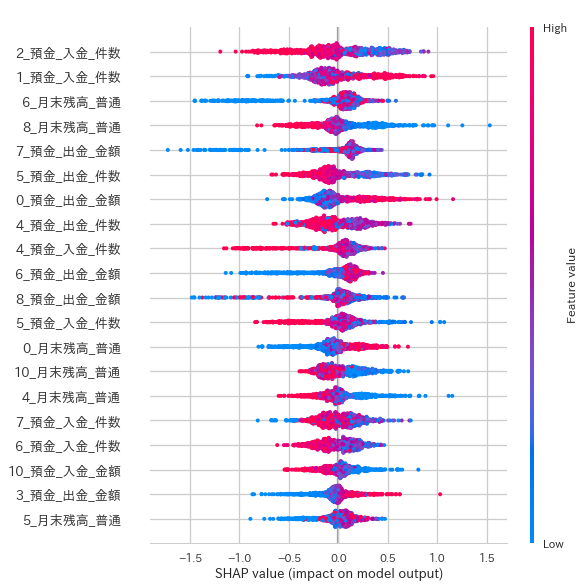

In [12]:
shap.summary_plot(shap_values, X_test)

### Dependence Plot

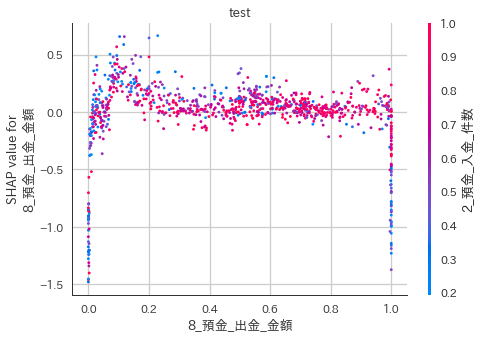

In [13]:
ax = shap.dependence_plot('8_預金_出金_金額', shap_values, X_test, show=False, dot_size=8, title='test')

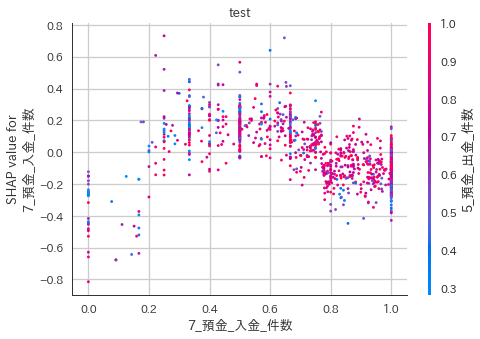

In [14]:
ax = shap.dependence_plot('7_預金_入金_件数', shap_values, X_test, show=False, dot_size=8, title='test')
# plt.xlim([0,0.1*10**11])

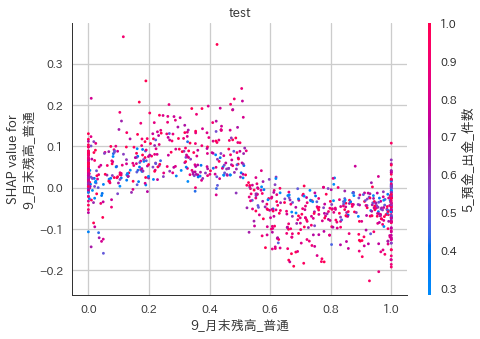

In [24]:
ax = shap.dependence_plot('9_月末残高_普通', shap_values, X_test, show=False, dot_size=8, title='test')
# plt.xlim([0,0.1*10**11]) 

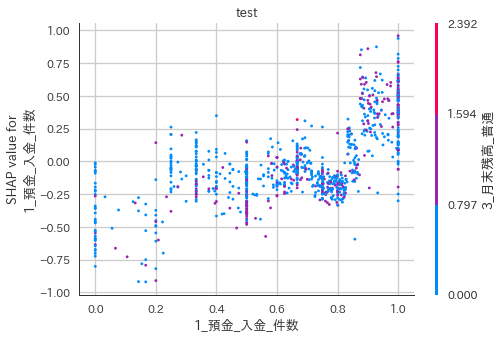

In [16]:
ax = shap.dependence_plot('1_預金_入金_件数', shap_values, X_test, show=False, dot_size=8, title='test')

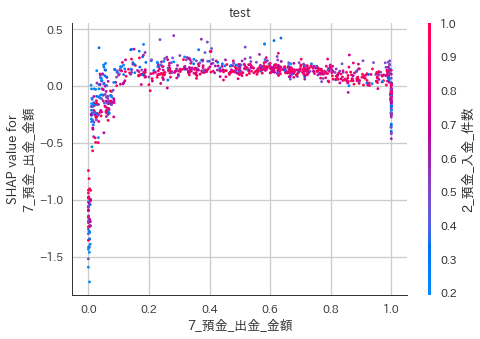

In [17]:
ax = shap.dependence_plot('7_預金_出金_金額', shap_values, X_test, show=False, dot_size=8, title='test')

### Force Plot

#### 正解:劣化, 予測:劣化

In [18]:
shap.force_plot(explainer.expected_value, shap_values[ind_rekka_rekka[0],:], X_test.loc[ind_rekka_rekka[0],:])

In [19]:
shap.force_plot(explainer.expected_value, shap_values[ind_rekka_rekka[1],:], X_test.loc[ind_rekka_rekka[1],:])

In [20]:
shap.force_plot(explainer.expected_value, shap_values[ind_rekka_rekka[2],:], X_test.loc[ind_rekka_rekka[2],:])

#### 正解:正常, 予測:正常

In [21]:
shap.force_plot(explainer.expected_value, shap_values[ind_seijo_seijo[0],:], X_test.loc[ind_seijo_seijo[0],:])

In [22]:
shap.force_plot(explainer.expected_value, shap_values[ind_seijo_seijo[1],:], X_test.loc[ind_seijo_seijo[1],:])

In [23]:
shap.force_plot(explainer.expected_value, shap_values[ind_seijo_seijo[2],:], X_test.loc[ind_seijo_seijo[2],:])